In [ ]:
#Encerrar a conexão com os dispositivos
DAC.close()
scope.close()
rm.close()


In [123]:
import pyvisa as pv
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio   
import pickle
import scipy.signal
from tqdm.notebook import tqdm, trange
from scipy.special import erfc
import scipy as sp
from optic.comm.modulation import modulateGray, demodulateGray, GrayMapping
from optic.dsp.core import firFilter, pulseShape, lowPassFIR, pnorm, upsample, decimate,clockSamplingInterp
from optic.comm.metrics import signal_power,fastBERcalc
from optic.dsp.equalization import *
from optic.plot import eyediagram
plt.rcParams["figure.figsize"] = (12,6)

from funcoesLab import *

In [124]:
# #Conectar dispositivos

rm = pv.ResourceManager()
print(rm.list_resources())

DAC = rm.open_resource('USB0::0x0957::0x5707::MY53802202::0::INSTR')

print('info DAC:', DAC.query('*IDN?'))

DAC.write('*rst')
DAC.write('*opc?') 

scope = rm.open_resource('USB0::0x2A8D::0x1768::MY55440748::0::INSTR')
print('Info Osciloscopio:', scope.query('*IDN?'))
scope.write('*rst')
scope.write('*opc?') 

np.set_printoptions(threshold=np.inf)
del DAC.timeout
print('')

('USB0::0x0957::0x5707::MY53802202::0::INSTR', 'USB0::0x2A8D::0x1768::MY55440748::0::INSTR')
info DAC: Agilent Technologies,33622A,MY53802202,A.01.11-2.25-03-64-02

Info Osciloscopio: KEYSIGHT TECHNOLOGIES,DSO-X 3014T,MY55440748,04.06.2015051201




In [165]:
Modulador = {
    'M': 4,
    'nsimbolos': 1e5,
    'SPS': 2,
    'formatoPulso': 'rrc', #'rect','nrz','rrc'
    'nTaps': 1024,
    'alpha': 0.01,
    'W': np.array([])
}

Dac = {
    'dispositivo': DAC,
    'Porta': 2,
    'fs': 500e6,
    'V_High': 4,
    'V_Low': 0,
    'filtro': 'NORMal'
}

Osciloscopio = {
    'dispositivo': scope,
    'canais': np.array([3]),
    'tempo': Modulador['nsimbolos']/(Dac['fs']),
    'vDivisao': np.array([0.8]),
    'impedancia': np.array(['FIFTy']),
    'triggerChannel': np.array([0]),
    'triggerAmp': np.array([0]),
    'offset': np.array([2]),
}
#Gerando os sinais transmitidos
bits, transmitido, transmitidoequalizados = Gerar_Simbolos(Modulador)
#Gerando uma onda arbitraria no DAC
Onda_Dac_Keysight(Dac,Modulador,transmitido,'teste')
DAC.query('*OPC?')   
#Configurando o osciloscopio
ConfigurarScope(Osciloscopio)
# Fixar o sinal no osciloscopio
Osciloscopio['dispositivo'].write('digitize')
Osciloscopio['dispositivo'].query('*OPC?')   

t,recebido = AdquirirOnda(Osciloscopio['dispositivo'],3)
fsScope = float(Osciloscopio['dispositivo'].query(':ACQuire:SRATe?'))

print(f'Numero de pontos do osciloscopio: {len(recebido)}')
print(f'Frequencia de amostragem do osciloscopio: {round(fsScope*1e-6,3)} MHz')



+0,"No error"

Numero de pontos do osciloscopio: 1000000
Frequencia de amostragem do osciloscopio: 5000.0 MHz


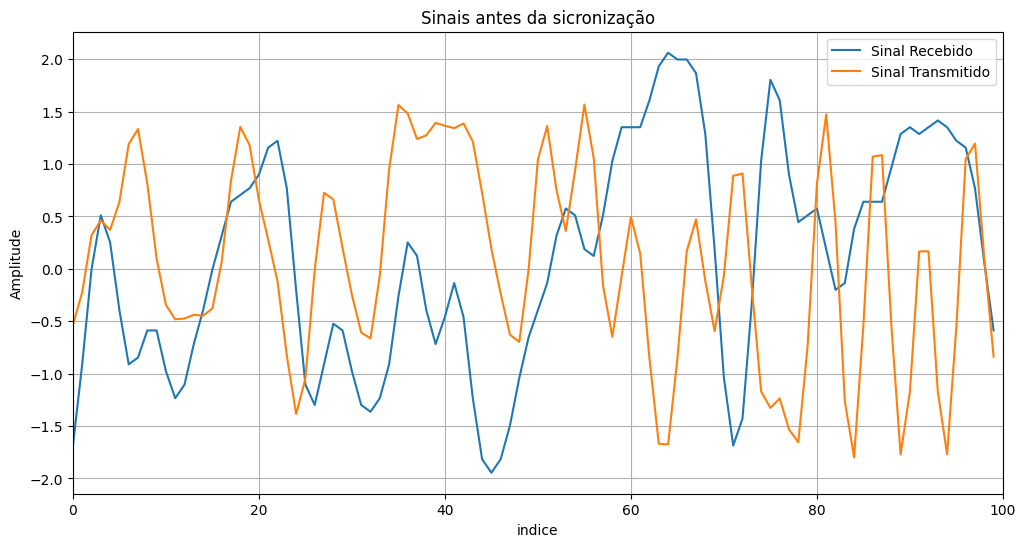

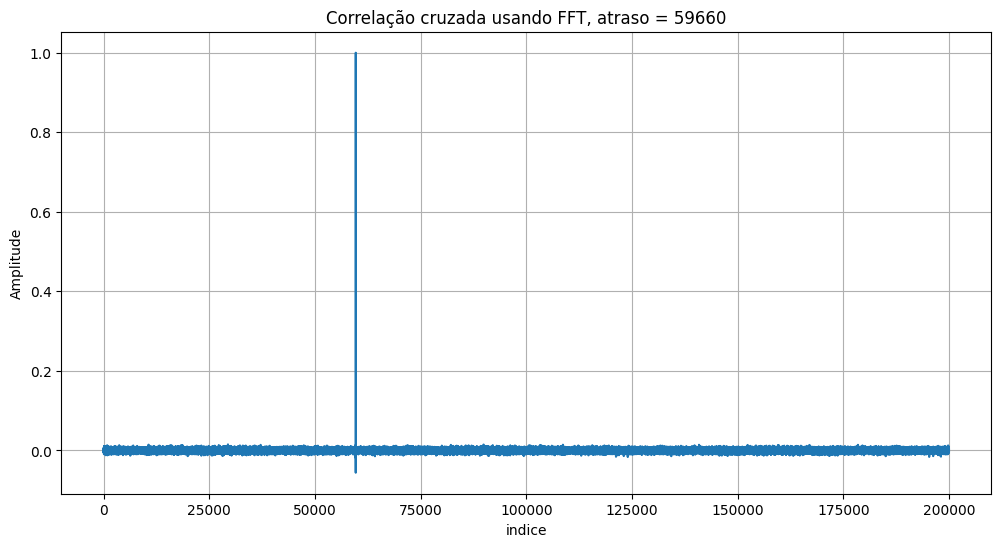

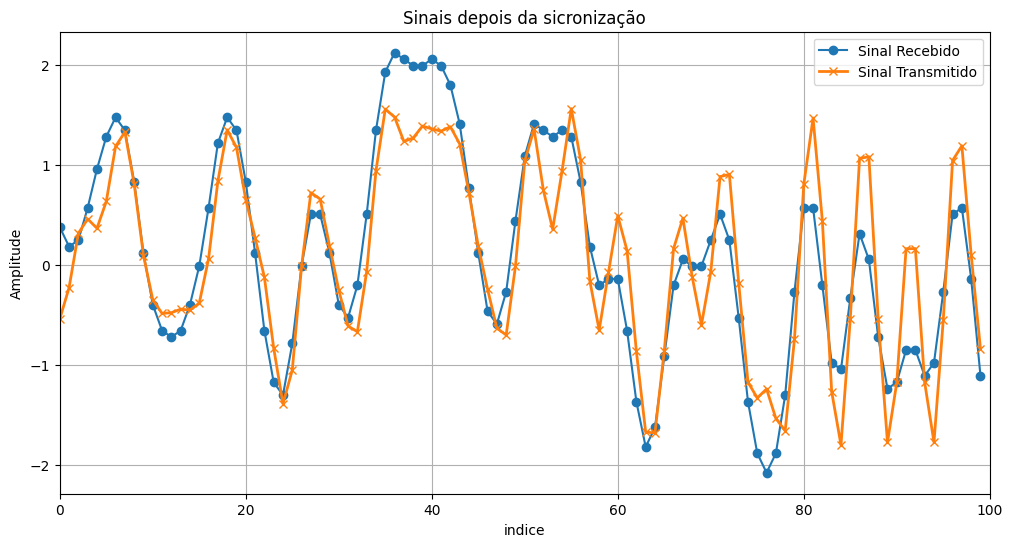

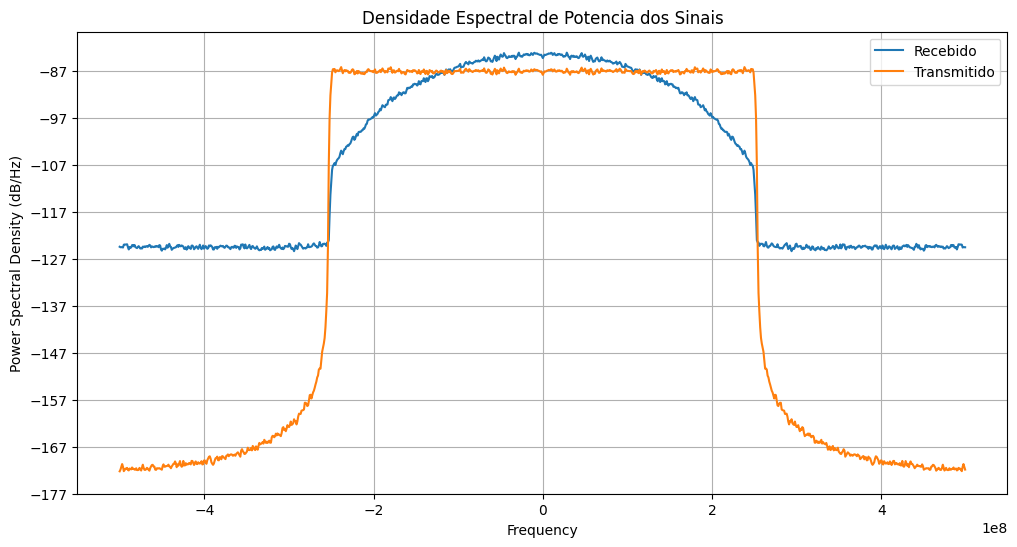

In [150]:
transmitido = pnorm(transmitido-np.mean(transmitido))

recebidodecimado = clockSamplingInterp(recebido.reshape(-1,1),Fs_in=fsScope,Fs_out=Dac['fs']*Modulador['SPS'],jitter_rms=0)[:,0]
recebidodecimado = pnorm(recebidodecimado-np.mean(recebidodecimado))

plt.figure()
plt.plot(recebidodecimado[0:100],label='Sinal Recebido')
plt.plot(transmitido[0:100],label='Sinal Transmitido')
plt.xlim(0,100)
plt.xlabel('indice')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()
plt.title('Sinais antes da sicronização')


recebidosicronizado = sicronizarSinais(recebidodecimado,(transmitido),plot=True)
recebidosicronizado = pnorm(recebidosicronizado-np.mean(recebidosicronizado))

plt.figure()
plt.plot(recebidosicronizado[0:100],'-o',label='Sinal Recebido')
plt.plot(transmitido[0:100],'-x',linewidth='2',label='Sinal Transmitido')
plt.xlim(0,100)
plt.xlabel('indice')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()
plt.title('Sinais depois da sicronização')

plt.figure()
plt.title('Densidade Espectral de Potencia dos Sinais')
plt.psd(recebidosicronizado,Fs=1e9, NFFT = 1024, sides='twosided', label = 'Recebido')
plt.psd(transmitido,Fs=1e9, NFFT = 1024, sides='twosided', label = 'Transmitido')
plt.legend()


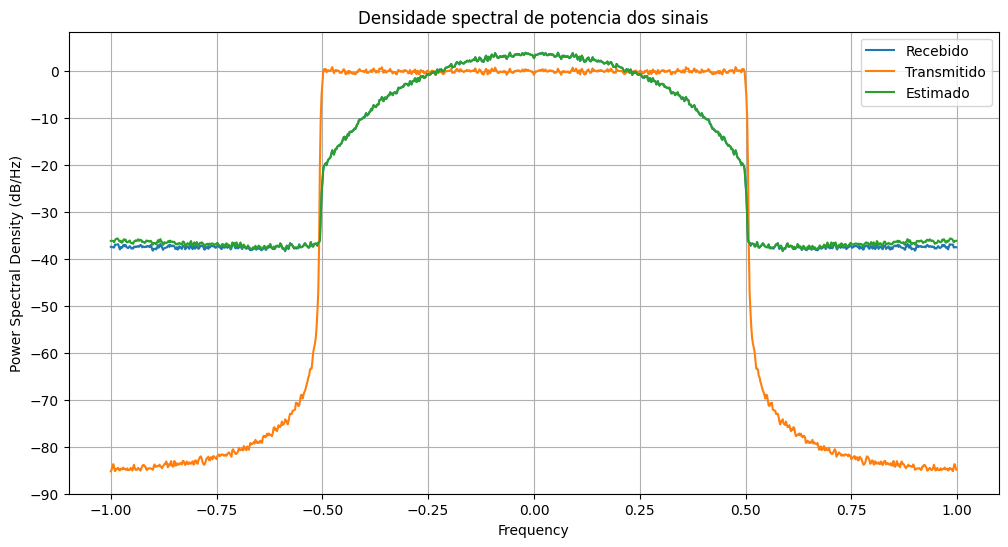

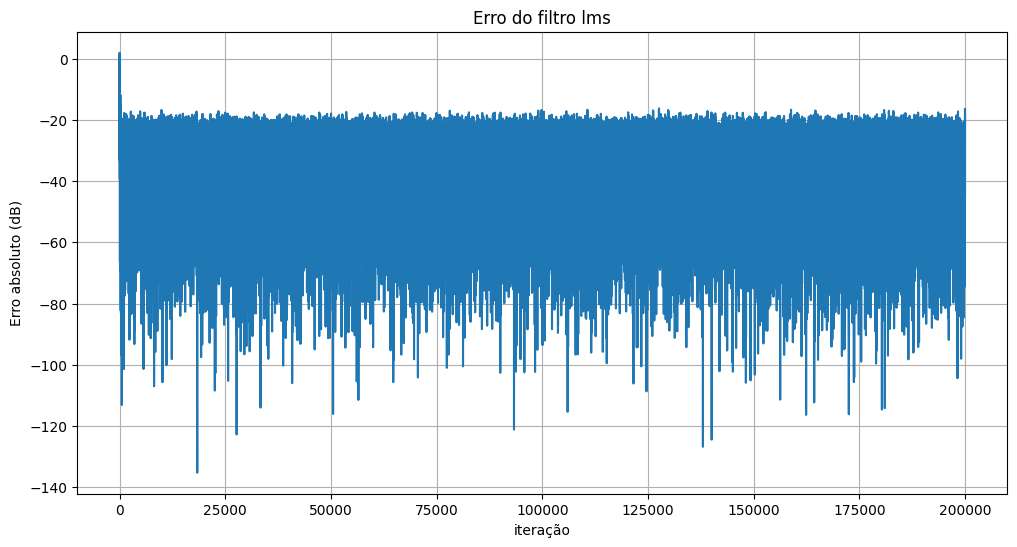

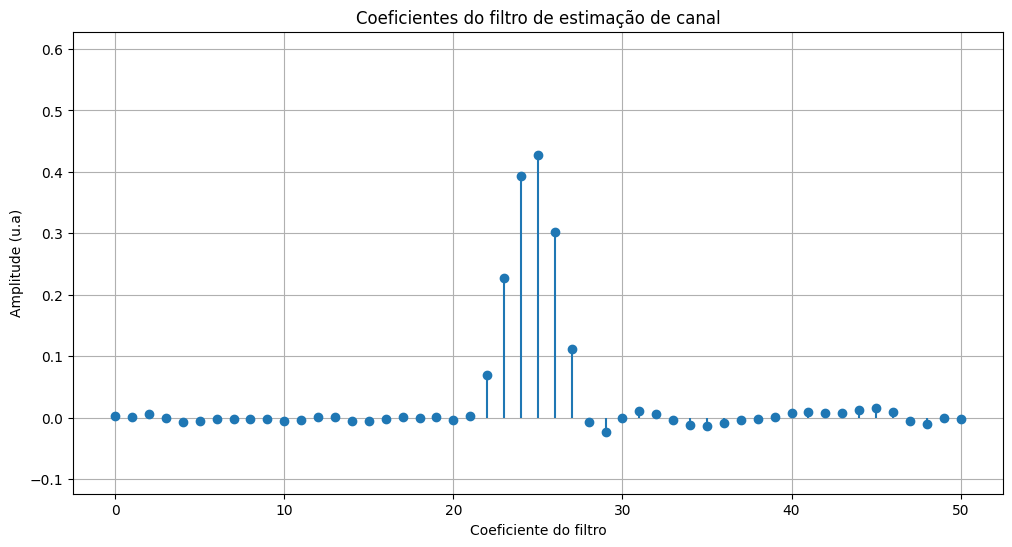

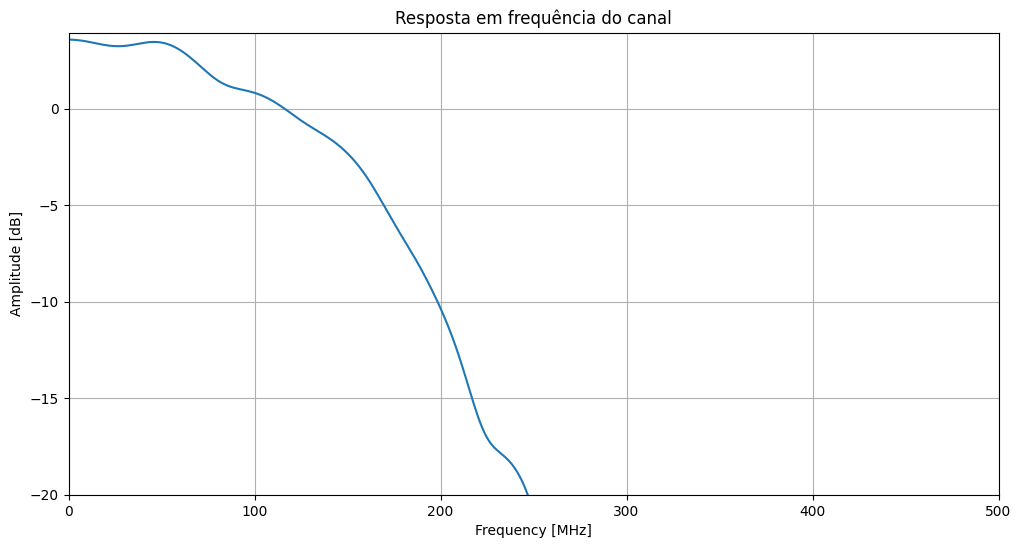

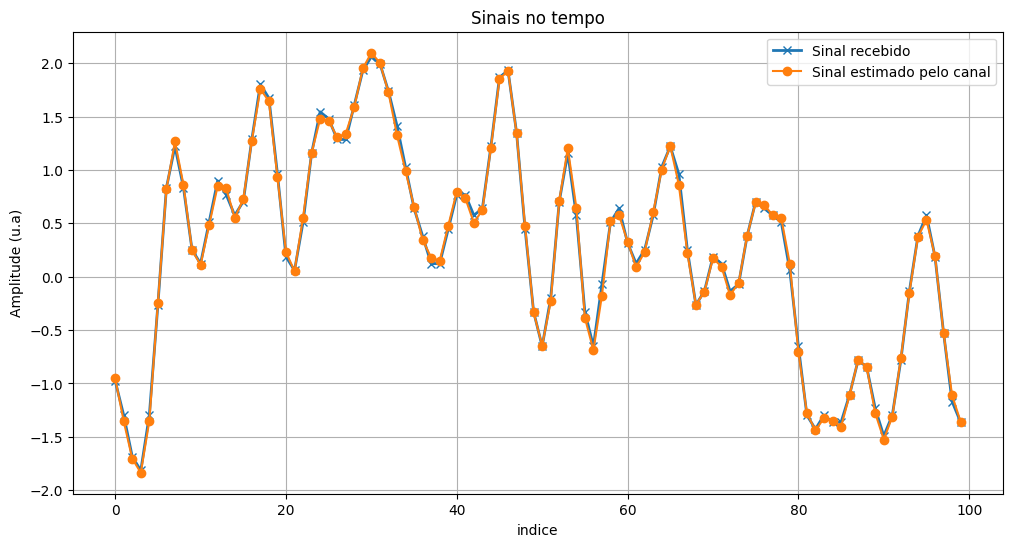

In [151]:
#Estimação do canal

#filtro lms
L = 51
μ = 0.02
out, h ,erro = lms(transmitido, recebidosicronizado, L,μ)
out = pnorm(out-np.mean(out))

plt.figure()
plt.psd(recebidosicronizado, NFFT = 1024, sides='twosided', label = 'Recebido')
plt.psd(transmitido,NFFT = 1024, sides='twosided', label = 'Transmitido')
plt.psd(out, sides='twosided',NFFT = 1024, label = 'Estimado')
plt.legend()
plt.title('Densidade spectral de potencia dos sinais')

plt.figure()
plt.plot(10*np.log10(erro))
plt.xlabel('iteração')
plt.ylabel('Erro absoluto (dB)')
plt.title('Erro do filtro lms')
plt.grid()

plt.figure()
plt.stem(np.arange(len(h)), h, basefmt=" ")
plt.grid()
plt.ylim(min(h)-0.1,max(h)+0.2)
plt.xlabel('Coeficiente do filtro')
plt.ylabel('Amplitude (u.a)')
plt.title('Coeficientes do filtro de estimação de canal')

plt.figure()
fs = Dac['fs']*Modulador['SPS']
ω, h = sp.signal.freqz(b=h, a=1)
x = ω * fs * 1.0 / (2 * np.pi)
y = 20*np.log10(np.abs(h))

plt.plot(x/1e6, y)
plt.title('Resposta em frequência do canal')
plt.grid()
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [MHz]')
plt.xlim(0,1*Dac['fs']/1e6)
plt.ylim(-20,1.1*np.max(y))

plt.figure()
plt.plot(recebidosicronizado[500:600],'-x',linewidth='2',label='Sinal recebido')
plt.plot(out[500:600],'-o',label='Sinal estimado pelo canal')
plt.xlabel('indice')
plt.ylabel('Amplitude (u.a)')
plt.title('Sinais no tempo')
plt.grid()
plt.legend()

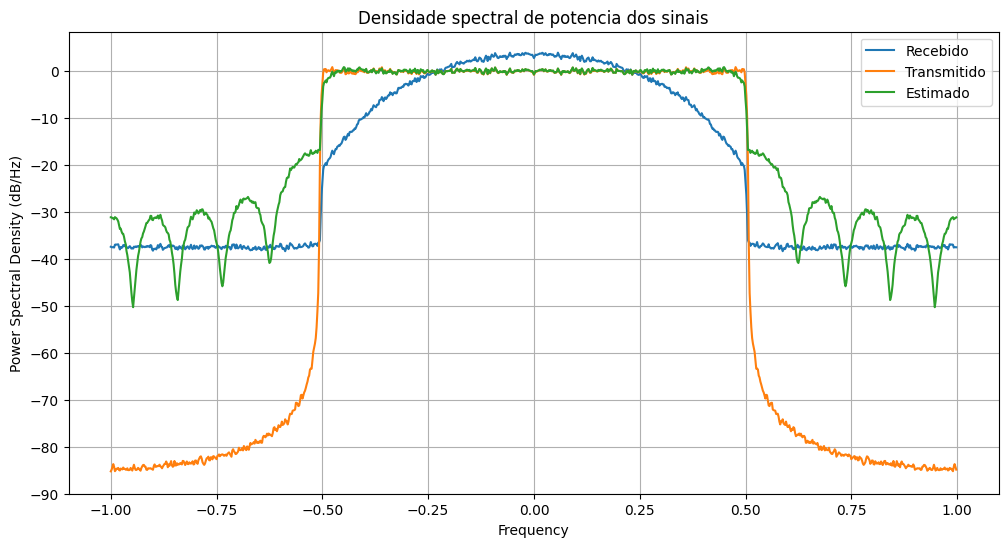

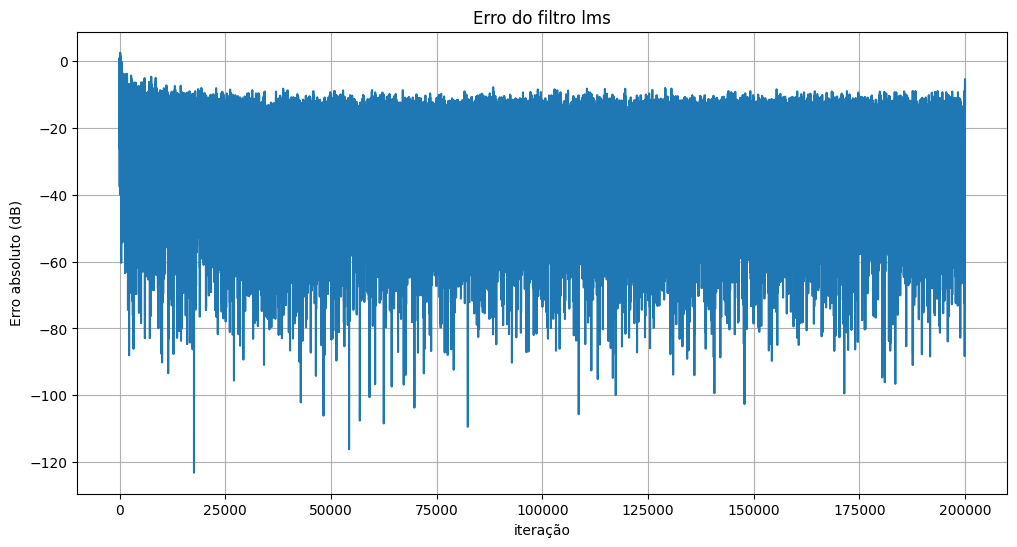

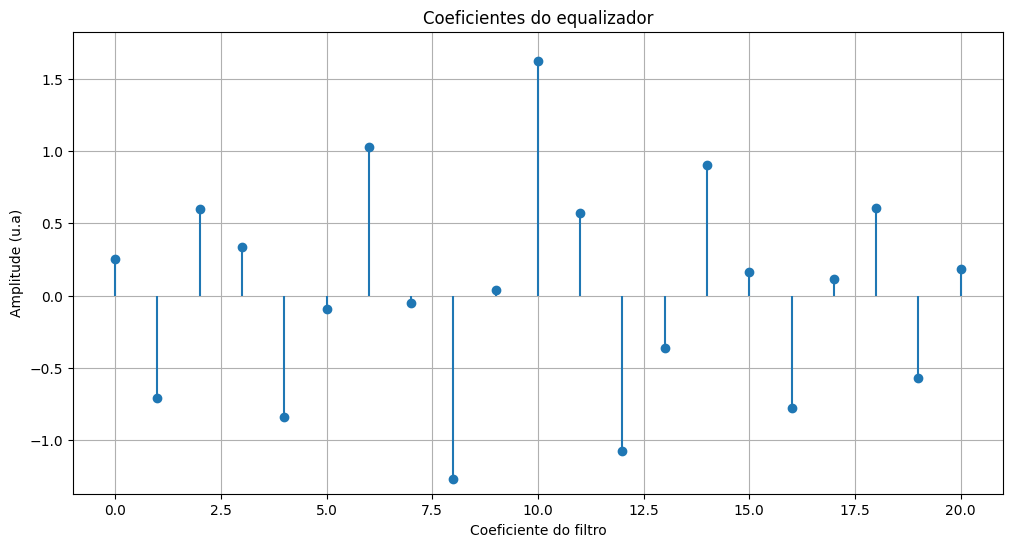

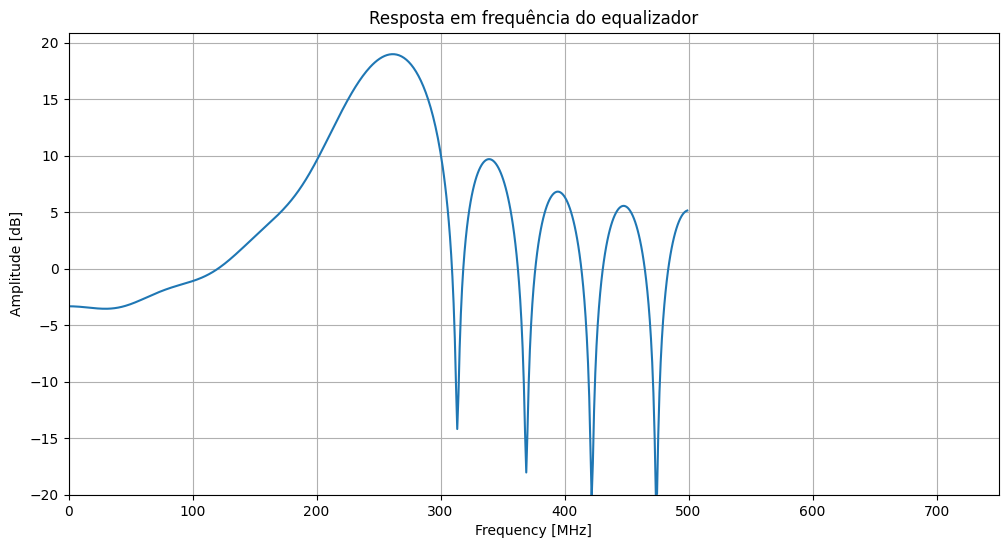

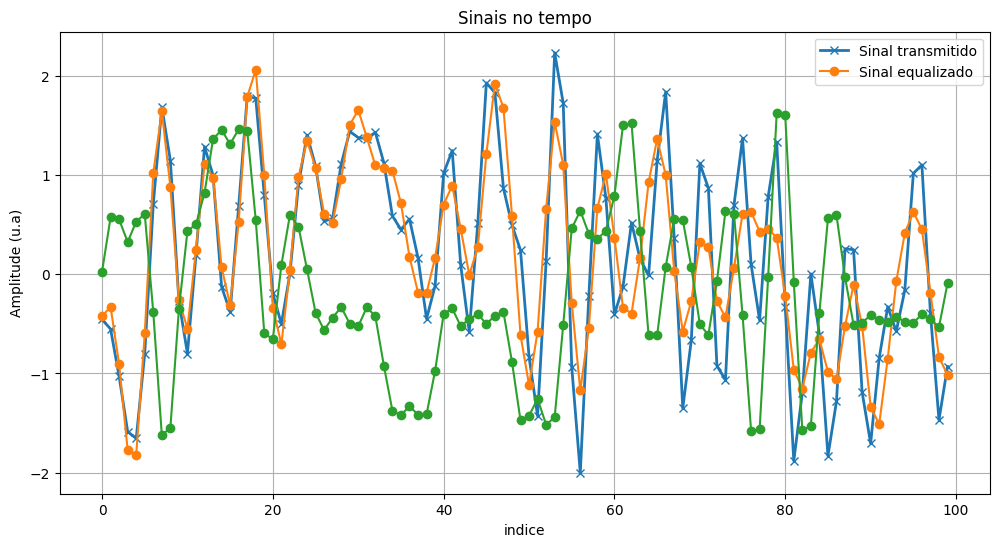

In [152]:
#Estimação do equalizador

#filtro lms
L = 21
μ = 0.015
out, heq ,erro = lms(recebidosicronizado, transmitido, L,μ)
out = pnorm(out-np.mean(out))



plt.figure()
plt.psd(recebidosicronizado, NFFT = 1024, sides='twosided', label = 'Recebido')
plt.psd(transmitido,NFFT = 1024, sides='twosided', label = 'Transmitido')
plt.psd(out, sides='twosided',NFFT = 1024, label = 'Estimado')
plt.legend()
plt.title('Densidade spectral de potencia dos sinais')

plt.figure()
plt.plot(10*np.log10(erro))
plt.xlabel('iteração')
plt.ylabel('Erro absoluto (dB)')
plt.title('Erro do filtro lms')
plt.grid()

plt.figure()
plt.stem(np.arange(len(heq)), heq, basefmt=" ")
plt.grid()
plt.ylim(min(heq)-0.1,max(heq)+0.2)
plt.xlabel('Coeficiente do filtro')
plt.ylabel('Amplitude (u.a)')
plt.title('Coeficientes do equalizador')

plt.figure()
fs = Dac['fs']*Modulador['SPS']
ω, h = sp.signal.freqz(b=heq, a=1)
x = ω * fs * 1.0 / (2 * np.pi)
y = 20*np.log10(np.abs(h))

plt.plot(x/1e6, y)
plt.title('Resposta em frequência do equalizador')
plt.grid()
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [MHz]')
plt.xlim(0,1.5*Dac['fs']/1e6)
plt.ylim(-20,1.1*np.max(y))

plt.figure()
plt.plot(transmitido[500:600],'-x',linewidth='2',label='Sinal transmitido')
plt.plot(out[500:600],'-o',label='Sinal equalizado')
plt.xlabel('indice')
plt.ylabel('Amplitude (u.a)')
plt.title('Sinais no tempo')
plt.grid()
plt.legend()


plt.plot(teste[500:600],'-o',label='Sinal equalizado 2')

# Realizando a pre-equalização

In [163]:
Modulador = {
    'M': 4,
    'nsimbolos': 1e5,
    'SPS': 2,
    'formatoPulso': 'rrc', #'rect','nrz','rrc'
    'nTaps': 1024,
    'alpha': 0.01,
    'W': heq
}

Dac = {
    'dispositivo': DAC,
    'Porta': 2,
    'fs': 500e6,
    'V_High': 4,
    'V_Low': 0,
    'filtro': 'NORMal'
}

Osciloscopio = {
    'dispositivo': scope,
    'canais': np.array([3]),
    'tempo': Modulador['nsimbolos']/(Dac['fs']),
    'vDivisao': np.array([0.2]),
    'impedancia': np.array(['FIFTy']),
    'triggerChannel': np.array([0]),
    'triggerAmp': np.array([0]),
    'offset': np.array([2]),
}
#Gerando os sinais transmitidos
bits, transmitido, transmitidoequalizados = Gerar_Simbolos(Modulador)
#Gerando uma onda arbitraria no DAC
Onda_Dac_Keysight(Dac,Modulador,transmitidoequalizados,'teste')
DAC.query('*OPC?')   
#Configurando o osciloscopio
ConfigurarScope(Osciloscopio)
# Fixar o sinal no osciloscopio
Osciloscopio['dispositivo'].write('digitize')
Osciloscopio['dispositivo'].query('*OPC?')   

t,recebido = AdquirirOnda(Osciloscopio['dispositivo'],3)
fsScope = float(Osciloscopio['dispositivo'].query(':ACQuire:SRATe?'))

print(f'Numero de pontos do osciloscopio: {len(recebido)}')
print(f'Frequencia de amostragem do osciloscopio: {round(fsScope*1e-6,3)} MHz')



+0,"No error"

Numero de pontos do osciloscopio: 1000000
Frequencia de amostragem do osciloscopio: 5000.0 MHz


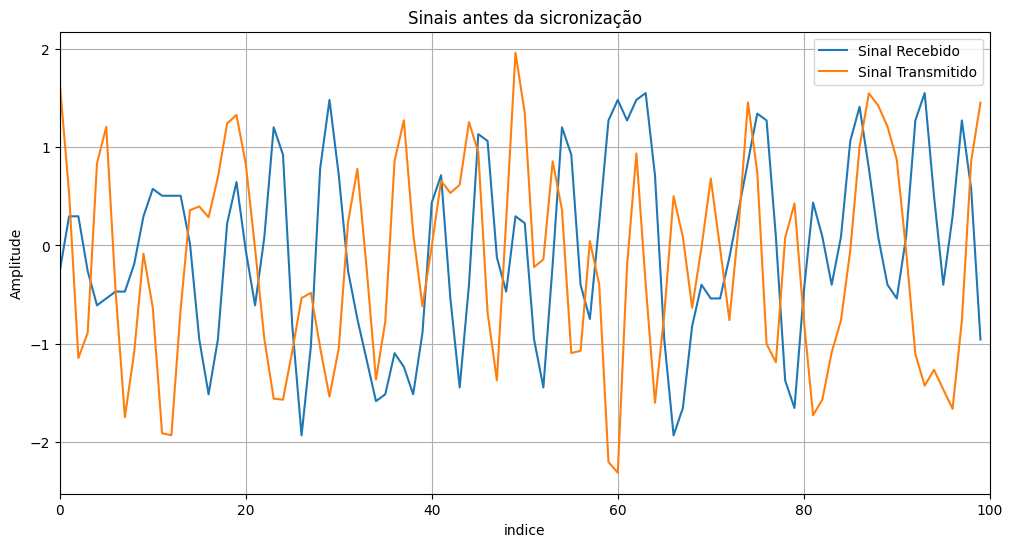

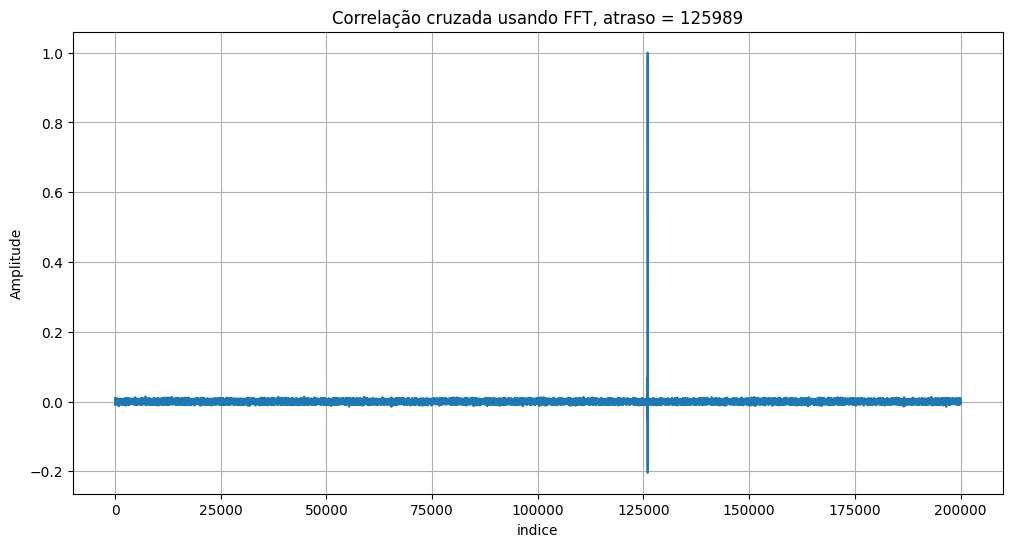

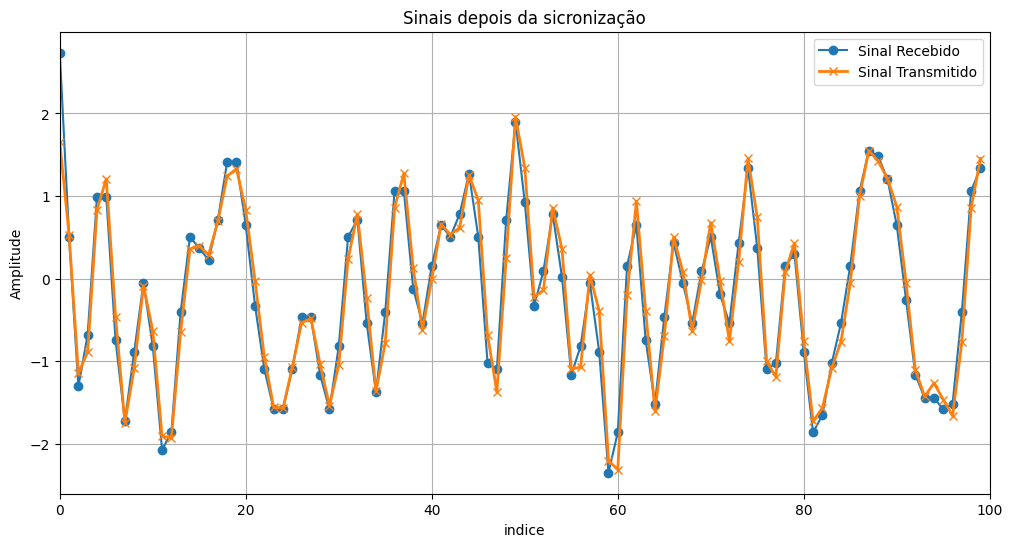

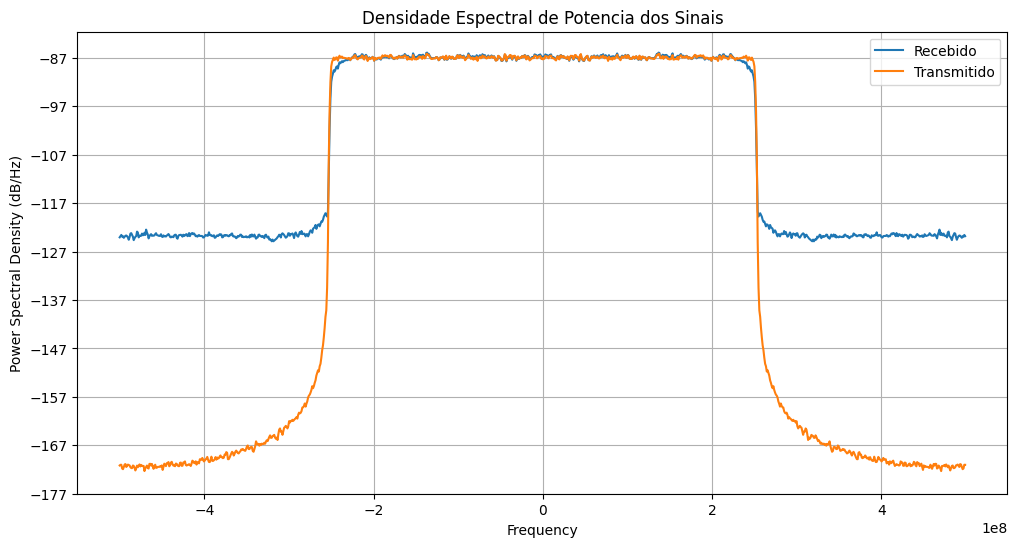

In [164]:
transmitido = pnorm(transmitido-np.mean(transmitido))

recebidodecimado = clockSamplingInterp(recebido.reshape(-1,1),Fs_in=fsScope,Fs_out=Dac['fs']*Modulador['SPS'],jitter_rms=0)[:,0]
recebidodecimado = pnorm(recebidodecimado-np.mean(recebidodecimado))

plt.figure()
plt.plot(recebidodecimado[0:100],label='Sinal Recebido')
plt.plot(transmitido[0:100],label='Sinal Transmitido')
plt.xlim(0,100)
plt.xlabel('indice')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()
plt.title('Sinais antes da sicronização')


recebidosicronizado = sicronizarSinais(recebidodecimado,(transmitido),plot=True)
recebidosicronizado = pnorm(recebidosicronizado-np.mean(recebidosicronizado))

plt.figure()
plt.plot(recebidosicronizado[0:100],'-o',label='Sinal Recebido')
plt.plot(transmitido[0:100],'-x',linewidth='2',label='Sinal Transmitido')
plt.xlim(0,100)
plt.xlabel('indice')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()
plt.title('Sinais depois da sicronização')

plt.figure()
plt.title('Densidade Espectral de Potencia dos Sinais')
plt.psd(recebidosicronizado,Fs=1e9, NFFT = 1024, sides='twosided', label = 'Recebido')
plt.psd(transmitido,Fs=1e9, NFFT = 1024, sides='twosided', label = 'Transmitido')
plt.legend()


107.80990874956625


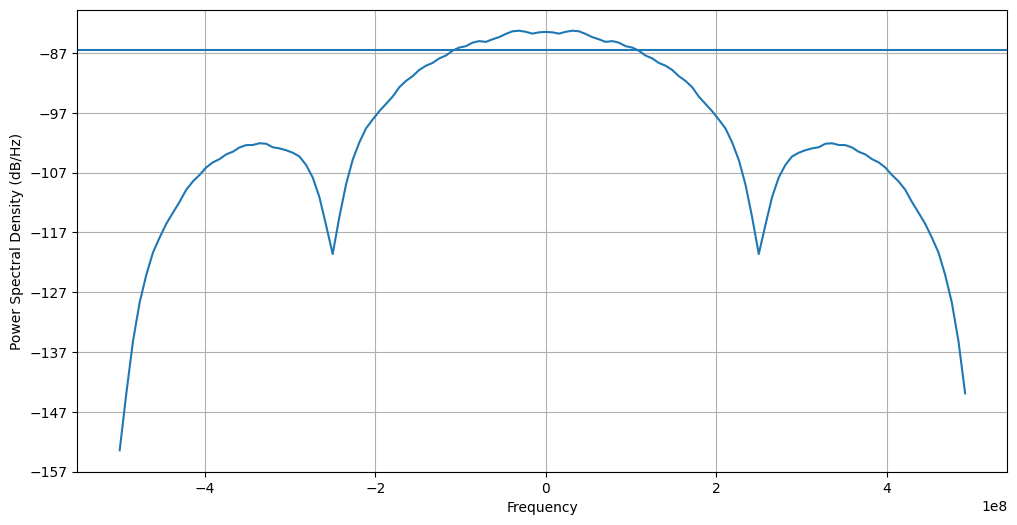

In [92]:
# x = np.linspace(-2,2,100)
# y = x**2 - 1
# plt.plot(x,y)

from scipy.interpolate import UnivariateSpline

p,f = plt.psd(pnorm(simbolos-np.mean(simbolos)),Fs=Modulador['SPS']*Dac['fs'], NFFT = 128, sides='twosided', label = 'Transmitido')
p = 10*np.log10(np.abs(p))
#plt.xlim(2*-600e6,600e6*2)

#create spline
spline = UnivariateSpline(f, p-(p[len(p)//2]-3), s=0)

# find the roots
r1, r2 = spline.roots()
plt.axhline(p[len(p)//2]-3)
# calculate the difference
threedB_bandwidth = abs(r2-r1)
print(r2*1e-6)